## Minimal test of XyloSamna and XyloMonitor
- Deploying a dummy network on Xylo a2 and Xylo a3 


In [1]:
import warnings
warnings.filterwarnings("ignore")

import samna
print(f'Samna version {samna.__version__}')

import numpy as np
import matplotlib.pyplot as plt
from rockpool.devices.xylo.syns61201 import config_from_specification as a2_config_from, mapper as a2_mapper, XyloSamna as a2_XyloSamna, XyloMonitor as a2_XyloMonitor
from rockpool.devices.xylo.syns65302 import config_from_specification as a3_config_from, mapper as a3_mapper, XyloSamna as a3_XyloSamna

from rockpool.transform.quantize_methods import channel_quantize
from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

Samna version 0.37.10.31+g52e7582d3.dirty
from samna.xyloA3.configuration import InputInterfaceConfig


### Build a Dummy network 

In [2]:
net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),
    Linear((63, 8)),
    LIF(8),
)

### Create a simple spiking input 


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [ True False False ... False False False]]


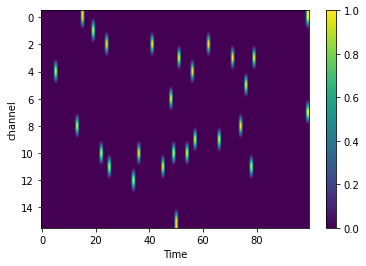

In [3]:
import matplotlib.pyplot as plt
T = 100  #number of time steps
dt = 0.01 #size of time step
Nin = 16 # number of input channels 
p = 0.02 # spiking probability
input_data = np.loadtxt('input_data.txt')
# input_data = np.random.rand(T,Nin) > (1-p)
# np.savetxt('input_data.txt', input_data)

input_data = np.array(input_data, dtype=bool)

print(input_data)
plt.figure()
plt.imshow(input_data.T, aspect='auto'); plt.xlabel('Time'); plt.ylabel('channel'); plt.colorbar()

### Detecting Xylos

In [4]:
from rockpool.devices.xylo import find_xylo_hdks
xylo_hdks, xylo_support_modules, xylo_versions = find_xylo_hdks()
print(xylo_hdks, xylo_support_modules, xylo_versions)

for version, xylo in zip(xylo_versions, xylo_hdks):
    if version == "syns61201":
        xa2_node = xylo
    elif version == "syns65302":
        xa3_node = xylo

print(xa2_node)
print(xa3_node)

The connected Xylo HDK contains a Xylo Audio v2 (SYNS61201). Importing `rockpool.devices.xylo.syns61201`
The connected Xylo HDK contains a Xylo A3. Importing `rockpool.devices.xylo.syns65302`
[<samna.xyloA2TestBoard.XyloA2TestBoard object at 0x7e80b88aec70>, <samna.xyloAudio3Boards.XyloAudio3TestBoard object at 0x7e80b8811770>] [<module 'rockpool.devices.xylo.syns61201' from '/home/vleite/Software/rockpool/rockpool/devices/xylo/syns61201/__init__.py'>, <module 'rockpool.devices.xylo.syns65302' from '/home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/__init__.py'>] ['syns61201', 'syns65302']
size of hidden neuron count 1
size of output neuron count 1


### Map it to Xylo a2
- and verify the weights

In [5]:
spec = a2_mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
a2_config, is_valid, msg = a2_config_from(**Q_spec)

if not is_valid:
    print(msg)

Text(0.5, 1.0, 'readout weights')

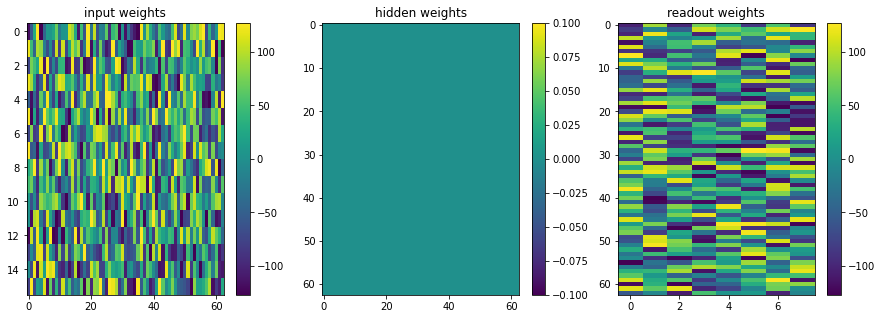

In [6]:
w_in = a2_config.input.weights
w_hid = a2_config.reservoir.weights
w_out = a2_config.readout.weights
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(w_in, aspect='auto'); plt.colorbar(); plt.title('input weights')
plt.subplot(132)
plt.imshow(w_hid, aspect='auto');plt.colorbar(); plt.title('hidden weights')
plt.subplot(133)
plt.imshow(w_out, aspect='auto');plt.colorbar(); plt.title('readout weights')

### Testing Xylo a2
- #### with XyloSamna 

[2024-04-16 16:00:16.344] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-16 16:00:16.344] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-16 16:00:16.345] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.


xyloCore2::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, synapse2_enable=0, bias_enable=1, direct_fetch_state_ram=0, enable_hibernation_mode=0, clear_network_state=1, time_resolution_wrap=0, hibernation_mode_time_resolution_wrap=0, input=xyloCore2::configuration::InputConfig(weight_bit_shift=0, weights={ -117 -57 29 127 -127 -43 8 6 22 69 -24 4 6 109 91 26 -111 48 -61 127 -28 105 -63 -14 -20 63 -96 43 59 -127 3 -115 -27 -85 -111 -127 123 2 91 30 -22 -60 55 9 -28 -40 50 113 -73 -34 116 -6 79 90 74 112 127 -72 38 -44 5 125 121 121 46 -45 97 85 -18 -67 -9 -74 108 -79 109 -72 21 101 62 94 -87 -24 122 -118 31 -74 73 -53 -111 -92 127 -55 21 -12 -55 -127 -124 49 17 11 72 43 49 79 -108 -4 127 -85 -94 127 87 121 -100 52 44 -8 -71 127 36 99 -57 -24 127 -127 42 -127 -74 74 50 22 121 -113 127 -75 -10 -71 39 40 -116 -106 124 -88 -83 77 -123 -110 -86 127 -4 60 35 -59 -66 21 127 119 -122 -92 -28 -48 100 29 -88 48 -28 -12 -6 38 -120 54 -76 52 47 -15 -64 -12 62 30 0 18 -1 86 11 

[2024-04-16 16:00:16.983] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.


dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out', 'times'])


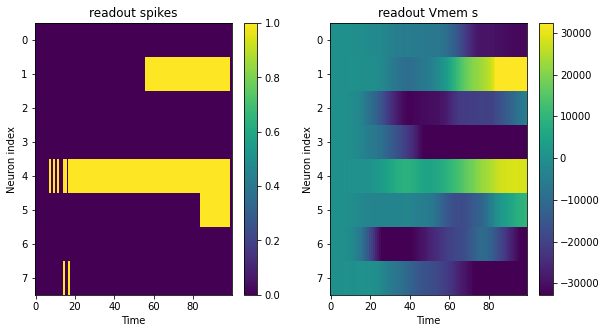

In [7]:
dt = 0.01
Xmod = a2_XyloSamna(xa2_node, a2_config, dt = dt)
print(Xmod.config)

out, _, rec = Xmod.evolve(input_data, record = True)
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(out.T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
plt.subplot(132), plt.imshow(rec['Vmem_out'].T, aspect='auto', interpolation='none');  plt.title('readout Vmem s'); plt.xlabel('Time'); plt.ylabel('Neuron index');  plt.colorbar()
print(rec.keys())

- #### With XyloMonitor
- clapping for 3 seconds

In [7]:

N = 3 # in seconds 
duration = int(N * (1/dt)) 
print(duration)

a2_Monitor = a2_XyloMonitor(xa2_node, a2_config, dt = dt)
out, _, rec = a2_Monitor.evolve(np.zeros((duration , Nin)))
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(np.array(out).T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()


300
Configuring AFE...


[2024-04-16 15:15:24.021] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-16 15:15:24.021] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-16 15:15:24.022] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.
[2024-04-16 15:15:24.022] [Graph] [warning] Graph is destroyed without any start! Graph is required to start manually to work.


KeyboardInterrupt: 

### Testing with XyloSamna for Xylo a3

### Map it to Xylo a3
- and verifying the weights

In [8]:
spec = a3_mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
a3_config, is_valid, msg = a3_config_from(**Q_spec)

if not is_valid:
    print(msg)

Text(0.5, 1.0, 'readout weights')

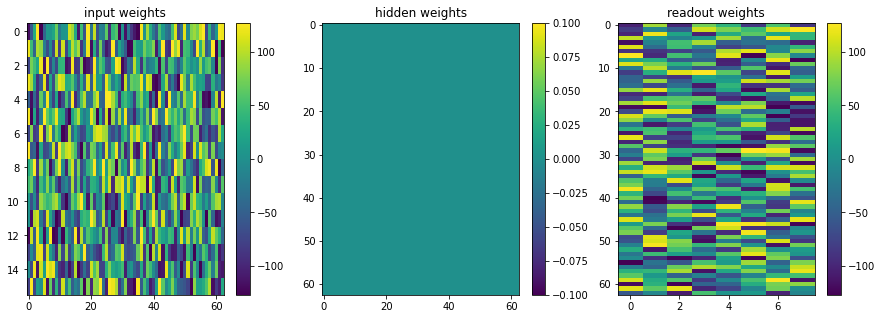

In [9]:
w_in = a3_config.input.weights
w_hid = a3_config.hidden.weights
w_out = a3_config.readout.weights
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(w_in, aspect='auto'); plt.colorbar(); plt.title('input weights')
plt.subplot(132)
plt.imshow(w_hid, aspect='auto');plt.colorbar(); plt.title('hidden weights')
plt.subplot(133)
plt.imshow(w_out, aspect='auto');plt.colorbar(); plt.title('readout weights')

In [10]:
a3_config.debug.ram_power_enable = 1
a3_config.debug.isyn_clock_enable = 1
a3_config.debug.bias_clock_enable=1
a3_config.debug.hm_clock_enable= 1

# a3_config.operation_mode = samna.xyloAudio3.OperationMode.Manual
# a3_config.debug.i2c_clock_freq_div = 0
# a3_config.debug.sdm_module_clock = 1
# a3_config.debug.adc_module_clock = 0
# a3_config.debug.spk2saer_module_clock = 0
# a3_config.debug.enable_spike2_saer_module = 1

# a3_config.digital_frontend.mode = samna.xyloAudio3.DigitalFrontendMode.Pdm
# # a3_config.time_resolution_wrap = 500000
# # a3_config.debug.debug_status_update_enable = 1
# # a3_config.debug.debug_input_enable = 1
# # a3_config.debug.monitor_signals_enable = 1
# # # 0: input for Xylo, 1: Xylo output
# a3_config.digital_frontend.pdm_preprocessing.clock_direction = 0
# # # 0: Xylo samples PDM_DATA at risinge edge, 1: Xylo samples PDM_DATA at falling edge
# # a3_config.digital_frontend.pdm_preprocessing.clock_edge = 1

# a3_config.digital_frontend.filter_bank.use_global_iaf_threshold = 1
# a3_config.digital_frontend.select_microphone_if=1
# a3_config.digital_frontend.bfi_enable=1

# # a3_config.debug.enable_i2c = 1
# # a3_config.debug.enable_sdm = 1

# # # config.debug.enable_adc = 1

# # # config.debug.enable_ana_testmode_control = 0
# # # config.debug.enable_sadc_if = 0

# # # config.debug.i2cClockFreqDiv;

# # # # others for test
# # #config.debug.saer_if_enable = 1
# # a3_config.hidden.aliasing = 1
# # a3_config.bias_enable = 1
# # a3_config.debug.always_update_omp_stat = 1


In [11]:
dt = 0.01
Xmod = a3_XyloSamna(xa3_node, a3_config, dt = dt)

print(Xmod.config)

out, _, rec = Xmod.evolve(input_data, record = True)

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, bias_enable=1, enable_hibernation_mode=0, time_resolution_wrap=0, if_input_enable=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ -117 -57 29 127 -127 -43 8 6 22 69 -24 4 6 109 91 26 -111 48 -61 127 -28 105 -63 -14 -20 63 -96 43 59 -127 3 -115 -27 -85 -111 -127 123 2 91 30 -22 -60 55 9 -28 -40 50 113 -73 -34 116 -6 79 90 74 112 127 -72 38 -44 5 125 121 121 46 -45 97 85 -18 -67 -9 -74 108 -79 109 -72 21 101 62 94 -87 -24 122 -118 31 -74 73 -53 -111 -92 127 -55 21 -12 -55 -127 -124 49 17 11 72 43 49 79 -108 -4 127 -85 -94 127 87 121 -100 52 44 -8 -71 127 36 99 -57 -24 127 -127 42 -127 -74 74 50 22 121 -113 127 -75 -10 -71 39 40 -116 -106 124 -88 -83 77 -123 -110 -86 127 -4 60 35 -59 -66 21 127 119 -122 -92 -28 -48 100 29 -88 48 -28 -12 -6 38 -120 54 -76 52 47 -15 -64 -12 62 30 0 18 -1 86 11 51 62 -8 -127 77 -94 120 93 18 -93 -50 118 -96 19 -68 71 118 107 28 31 59 -6 -64 36 -49 

  0%|          | 0/100 [00:00<?, ?it/s]

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out'])


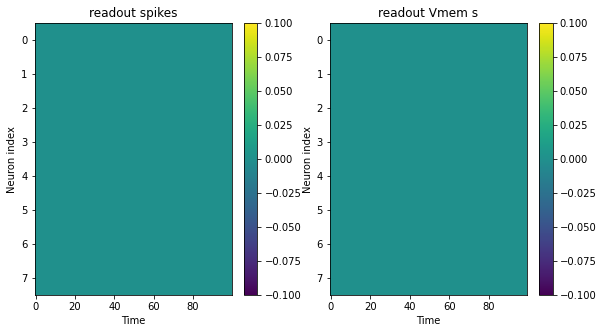

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(out.T, aspect='auto', interpolation='none'); plt.title('readout spikes'); plt.xlabel('Time'); plt.ylabel('Neuron index'); plt.colorbar()
plt.subplot(132), plt.imshow(rec['Vmem_out'].T, aspect='auto', interpolation='none');  plt.title('readout Vmem s'); plt.xlabel('Time'); plt.ylabel('Neuron index');  plt.colorbar()
print(rec.keys())